# Predicting loan payback using single Decision Tree vs Random Forest on Lending Club data set

**Summary**

This workbook attempts to create a model based on lending data to predict whether the loan will be repaid in full or not.   

I used a decision tree initially, followed by a random forest.

Neither gave particularly brilliant performance.

I need to revisit this in the future, perhaps with better domain knowledge (it's a little unclear what specific features actually represent), larger dataset, or maybe using some sort of feature engineering. 

Lending Club 2007 - 2011 data available from www.Lendingclub.com (registration required for full access).  Alternative versions available via Kaggle https://www.kaggle.com/wendykan/lending-club-loan-data

The csv file used here is an abridged version of the data.

The model will look at a number of factors to see how possible it may be to predict from them whether a loan will be fully paid off or not:

Features in csv file:

* __credit.policy:__ 1 if customer meets credit underwriting criteria of LendingClub.com, else 0.
* __purpose:__ Purpose of loan (poss values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", "all_other").
* __int.rate:__ Interest rate of loan, expressed as proportion e.g. rate of 11% represented as 0.11. (LendingClub.com lends at various rates depending on perceived risk of borrower.)
* __installment:__ Number of monthly installments that are owed by the borrower if loan is funded.
* __log.annual.inc:__ Natural log of borrower's annual income (self-reported data - may not be reliable).
* __dti:__ Debt-to-income ratio of borrower (amount of debt divided by annual income).
* __fico:__ Borrower's FICO credit score (this value is a basically a credit rating).
* __days.with.cr.line:__ Number of days borrower has had a credit line.
* __revol.bal:__ Borrower's revolving balance (This is the amount unpaid at the end of the credit card billing cycle).
* __revol.util:__ Borrower's revolving line utilization rate (Amount of credit line used relative to total credit available).
* __inq.last.6mths:__ Borrower's number of inquiries by creditors (e.g. FICO requests) in last 6 months.
* __delinq.2yrs:__ Number of times borrower had been 30+ days overdue on payment in past 2 years.
* __pub.rec:__ Borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).
* __not.fully.paid:__ Indicates whether the loan was paid back in full or not.

We are assuming that __not.fully.paid__ is in some way dependent on one or more of the other independent variables and that we can therefore potentially create a model with which to predict it. 

## 1) Import Libraries

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2) Get the Data

### Have a quick look at file with text editor

In [245]:
!subl loan_data.csv 

In [229]:
# !head loan_data.csv # Can also use !head
# But don't use cat as risk notebook grinding to halt for large files

### Read file in

In [246]:
df = pd.read_csv('loan_data.csv')

## 3) Exploratory Data Analysis

### Check out dataframe contents

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


From the above we can see:<br> 
- No missing data.<br>
- No NaNs.<br>
- Features have variety of datatypes: int float and object (string presumably).

### See what dataframe looks like

In [248]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [249]:
df.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

### First look at summary data

In [250]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


The point of FICO is to give a guide of an individual's credit worthiness.  This seems like a feature it would be worth having a closer look at.

How does LendingClub's policy reflect or relate to FICO score?

Let's create a histogram of FICO scores for loans that did not met lending club criteria  - called directly on pandas dataframe with pd.hist()...

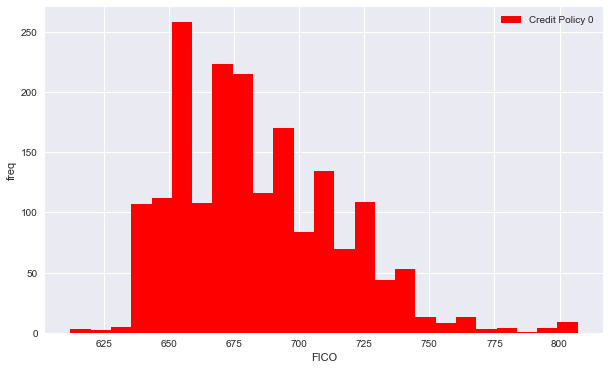

In [251]:
plt.figure(figsize=(10,6))
df[df['credit.policy']==0].fico.hist(bins=25, color='red', label='Credit Policy 0')
plt.legend()
plt.xlabel('FICO')
plt.ylabel('freq')

And here is a histogram of FICO scores for loans that met lending club criteria...

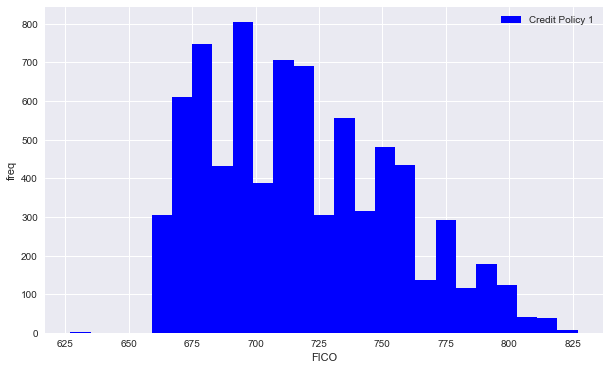

In [252]:
plt.figure(figsize=(10,6))
df[df['credit.policy']==1].fico.hist(bins=25, color='blue', label='Credit Policy 1')
plt.legend()
plt.xlabel('FICO')
plt.ylabel('freq')


Let's create a better visualisation which superimposes the above two plots...

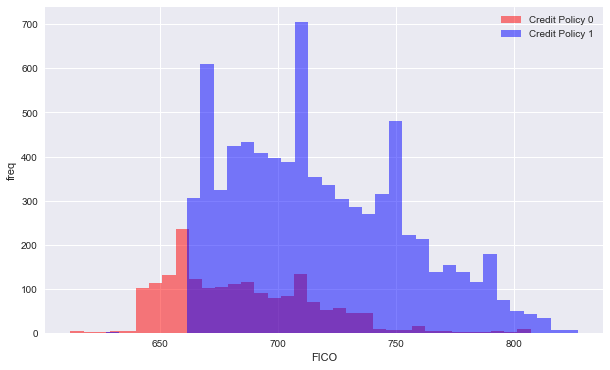

In [253]:
plt.figure(figsize=(10,6))
df[df['credit.policy']==0].fico.hist(bins=35, color='red', alpha=0.5, label='Credit Policy 0')

df[df['credit.policy']==1].fico.hist(bins=35, color='blue', alpha=0.5, label='Credit Policy 1')
plt.legend()
plt.xlabel('FICO')
plt.ylabel('freq')

From the above, we can see that whilst the credit policy doesn't clearly divide FICO scores into two regions,  on average, credit policy of 0 does reflect lower FICO scores than policy of 1.  However note the widely dispersed (long tailed) credit policy 0 distribution which suggests that individuals with high credit ratings could occasionally be rejected by the LendingClub policy.

Perhaps the FICO score is not as useful as it might have seemed.  Does it actually  suggest any potential for predicting whether the loan is fully paid or not? Let's plot FICO against not.fully.paid=0 and not.fully.paid=1...

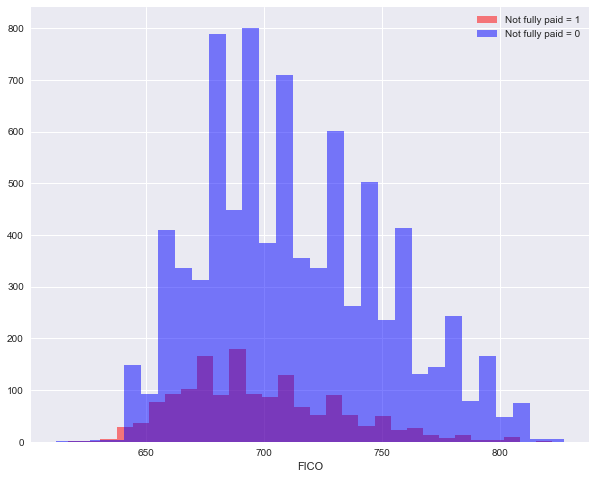

In [254]:
plt.figure(figsize=(10,8))
df[df['not.fully.paid']==1].fico.hist(bins=30, color='red', alpha=0.5, label='Not fully paid = 1')
df[df['not.fully.paid']==0].fico.hist(bins=30, color='blue', alpha=0.5, label='Not fully paid = 0')

plt.legend()
plt.xlabel('FICO')


From the above plot, it doesn't seem that FICO score will help us predict whether a loan will be paid off or not.

Is it possible that _purpose_ might have relationship to repayment, say for example purpose = debt consolidation??

Let's plot the count for each of the purpose classifications and divide each count according to whether the loan was paid off or not... 

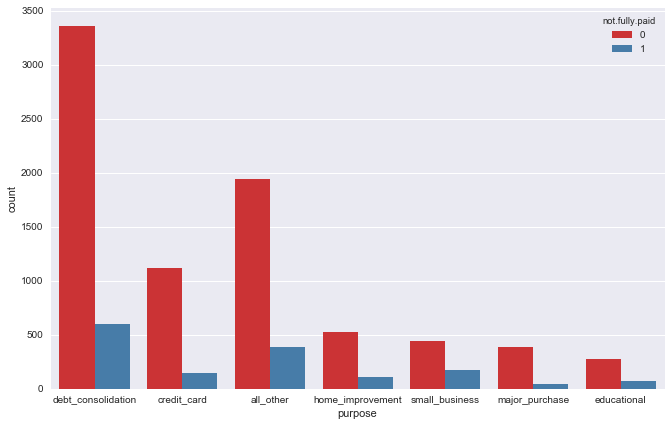

In [285]:
plt.figure(figsize=(11,7))
sns.countplot(x='purpose',hue='not.fully.paid',data=df,palette='Set1')

We can make some  general observations from the above plot:
- By far the greatest number of loans are for debt consolidation.
- In absolute terms debt consolidation results in higher numbers of unpaid loans than other categories.
- However proportionally speaking, It's not necessarily clear that people looking for debt consolidation are more likely to _not_ pay loans off (that relationship might be more the case for small_business loans, whilst at the other extreme, _major purchase_ and _credit card_ look like safer bets). 

We know that LendingClub charges higher interests to individuals with lower FICO scores. It would be worth  verifying that this correlation exists within the data.

Let's use a Seaborn jointplot to visualise the correlation between FICO score and interest rate...

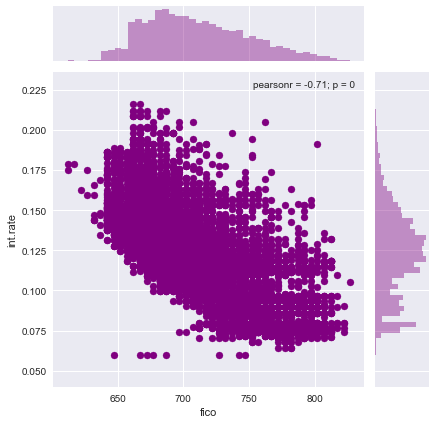

In [257]:
sns.jointplot('fico', 'int.rate', data=df, color='purple' )

There does appear to be a negative correlation between these two variables, as we expected, (although not with the sort of degree which might have any real predictive power).  
If we take the square of the Pearson  value, we get an r-squared value of:  

In [258]:
-0.71**2

-0.5041

Is it possible that the correlation between FICO and interest rates is perhaps more or perhaps less pronounced for non-payers vs payers?

Let's separate the above visualisation into two plots (paid vs not fully paid).  Whilst we are at ait we can look at how credit policy might be related to each of these two groups.  We'll create a linear model in the plot using seaborn's .lmplot() using paid vs not paid for each plot (_col_) and then subdividing each plot using _hue_ = credit.policy... 

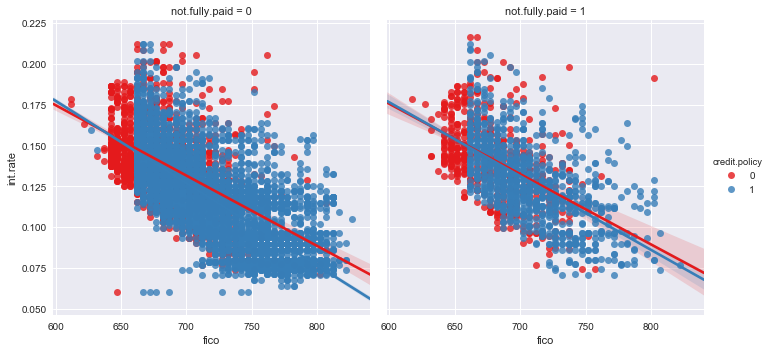

In [259]:
sns.lmplot('fico','int.rate', data=df, 
           col='not.fully.paid', hue='credit.policy', palette='Set1')

The two separate plots don't appear to give us any useful information.  It's hard to see any clear patterns in dividing by credit policy either.  All four linear models (represented by the red and blue lines in each plot) look very similar.

## 4) Data Preparation

### Deal with categorical variables

Let's have another look at our datatypes...

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


The _purpose_ column contains categorical features, which decision tree cannot manage. We need to create dummy variables to reflect each category.  We can do this simply and easily in pandas in one brief line.  (An alternative approach using sklearn.preprocessing library requires 2 steps with LabelEncoder and OneHotEncoder classes, before then dropping a feature.)  Create dummy variables...

In [261]:
cat_data= pd.get_dummies(data=df, columns=['purpose'], drop_first=True) 

(We drop one of the newly created categories to address multicolinearity - where we are effectively building redundant information into our training data - Effects on the target can't be isolated to a single individual causative feature. Or in other words, if x1 + x2 = c, where c is a constant, then we don't know whether change in y is _caused_ by x1 or x2). 

In [262]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [263]:
cat_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


The right hand side of cat\_data has multiple *purpose\_* features (dummy variables) and *purpose_all_other* has been dropped.

### Create X and y

In [286]:
X = cat_data.drop('not.fully.paid', axis=1) # for X data remove the target y values
X.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,1,0,0,0,0,0


In [288]:
y = cat_data['not.fully.paid'] # y data = target values                                                                                                                                                                                                                              
y.head()

0    0
1    0
2    0
3    0
4    0
Name: not.fully.paid, dtype: int64

### Train Test Split

In [266]:
from sklearn.model_selection import train_test_split

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Build models

### Create single decision tree model

Start by training a single decision tree.

In [268]:
from sklearn.tree import DecisionTreeClassifier

In [269]:
dtree = DecisionTreeClassifier()

In [270]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### Evaluate decision tree

In [271]:
y_pred = dtree.predict(X_test)

In [272]:
def get_some_basic_stats(y_test, y_pred):

    print('Size of test dataset: {}'.format(len(y_pred)))

    print('Number of y = class 0 predictions: {}'.format(sum([1 for y in y_pred if y==0]))) 
    print('Number of y = class 1 predictions: {}'.format(sum(y_pred))) 

    print('Number of misclassified values in the predictions: {}'.
        format(sum((y_test-y_pred)**2)))   

    print('Misclassification rate: {:.2f}'.format(sum((y_test-y_pred)**2)/len(y_pred)))

In [273]:
get_some_basic_stats(y_test, y_pred)

Size of test dataset: 2874
Number of y = class 0 predictions: 2336
Number of y = class 1 predictions: 538
Number of misclassified values in the predictions: 775
Misclassification rate: 0.27


In [274]:
from sklearn.metrics import confusion_matrix, classification_report

In [275]:
print(confusion_matrix(y_test, y_pred))

[[1996  435]
 [ 340  103]]


**Class 0 = fully paid**<br>
**Class 1 = not fully paid**<br>
<br>
There are 2431 fully paid loans(not.fully.paid = 0 i.e. paid). <br>
There are 443 not paid loans (not.fully.paid = 1)<br>
<br>
Of the 2431 fully paid loans, 2000 were accurately identified as paid.  431 loans that were actually paid were incorrectly predicted as not fully paid. 431 false negatives<br>
<br>
Of the 443 not paid loans, 104 were accurately identified as not paid.  339 loans that were actually not paid were incorrectly predicted to be not fully paid. 339 false positives.<br>

Note: Imbalanced classes - there are many more class 0 (fully paid) so if the model predicted all to be class 0, it would be right 2431(2431+443) 85% of time!

Let's look at precision and recall...

In [276]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.82      0.84      2431
          1       0.19      0.23      0.21       443

avg / total       0.75      0.73      0.74      2874



The model is good at predicting class 0 (fully paid), but poor at predicting class 1 (not fully paid) - Not good for a company lending money! The problem is compounded by the fact that of those items predicted to be class 1 (431 + 104 = 535), the quality of the prediction is poor - the majority of these (431) are actually class 0. <br>

Will a random forest model have greater predictive power?

### Create random forest model

In [277]:
from sklearn.ensemble import RandomForestClassifier

In [278]:
rfc = RandomForestClassifier(n_estimators=300)

In [279]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Evaluate random forest model

In [280]:
y_pred = rfc.predict(X_test)

In [281]:
get_some_basic_stats(y_test, y_pred)

Size of test dataset: 2874
Number of y = class 0 predictions: 2855
Number of y = class 1 predictions: 19
Number of misclassified values in the predictions: 444
Misclassification rate: 0.15


Note marked reduction in the number of y = class 1 predictions and also the reduced misclassification rate

In [282]:
from sklearn.metrics import confusion_matrix, classification_report

In [283]:
print(confusion_matrix(y_test, y_pred))

[[2421   10]
 [ 434    9]]


**Class 0 = fully paid**<br>
**Class 1 = not fully paid**<br>
<br>

Moving from decision tree to random forest has reduced the number of false negatives.  Previously we had 431 class 0 (fully paid) incorrectly classified as not fully paid.  This has now reduced to 7.<br>

Unfortunately though, our false positive rate is still very high.  In fact it has increased - we have lost a lot of our previously correctly predicted positives (not fully paid).  This means that we are now predicting fully paid for many examples where individuals have in reality failed to pay back loans. This model would expose the business to significant risk from non-payment of loans (more so than the single decision tree)


In [284]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92      2431
          1       0.47      0.02      0.04       443

avg / total       0.79      0.85      0.78      2874



We can see the improved ability of the random forest to find the fully paid examples and with 0.85 precision (quality) it is not pulling in a very large proportion of incorrectly classified class1s.
However, the recall result for the model when looking for class 1 shows that it is has almost no power to identify not.fully.paid individuals. With recall at 2%, precision is hardly worth worrying about (but at 0.5, it is not indicative of great quality in correctly finding class 1).   

The average f1 score on its own of 0.78 is a reminder of how metrics on the performance of models that are assessing imbalanced classes should be treated with caution. 